# Modèle ML

~~~~
Capteur:
* InletTemp-sensor
* SetTemp-sensor
* Drive-sensor
* Mode-sensor
~~~~

### 1. Nettoyer le jeu
* [x] Exploration des colonnes et drop des non nécessaires
* [x] Noter les intervalles ou listes pour chaque capteur
* [x] Features engineering (transformation des dates, merges, etc...)
* [x] Exclure les outliers n'étant pas dans les intervalles ou listes
* [x] Vérifier la présence de doublons
* [x] Exploration des données
* [x] API météo?

### 2. Modèle ML
* Modèle de Régression:
  * RandomTreeRegressor
  * Gradient Boosting (linéaire, tree)
  * KernelRidge (linéaire, rbf, etc...)
  * SVR

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from meteostat import Point, Daily, Hourly
from datetime import datetime

pd.set_option("display.max_columns", None)

sensors_datas = pd.read_csv("cleaned_datas_2.csv")

sensors_datas

,DataMeasurementId,DateTime,SensorId,Value,Raw,Name,EquipmentId,diff_time
0,1,2021-10-18 10:13:28.415,1,19.1,19.1,InletTemp-sensor,1,NaN
1,2,2021-10-18 10:13:28.446,2,29.0,29.0,SetTemp-sensor,1,0.031
2,3,2021-10-18 10:13:28.469,4,4.0,3005,FanSpeed-sensor,1,0.023
3,4,2021-10-18 10:13:28.481,5,2.0,HEAT,Mode-sensor,1,0.012
4,260,2021-10-18 11:34:33.376,1,19.2,19.2,InletTemp-sensor,1,4864.895
...,...,...,...,...,...,...,...,...
67818,67958,2021-11-21 13:00:05.206,109,22.3,22.3,InletTemp-sensor,19,1859.899
67819,67959,2021-11-21 13:00:05.217,110,19.0,19.0,SetTemp-sensor,19,0.011
67820,67960,2021-11-21 13:00:05.228,111,0.0,2,Drive-sensor,19,0.011
67821,67962,2021-11-21 13:00:05.249,113,2.0,HEAT,Mode-sensor,19,0.021


In [2]:
sensors_datas["DateTime_H"] = sensors_datas["DateTime"].astype("<M8[h]")
sensors_datas["DateTime_m"] = sensors_datas["DateTime"].astype("<M8[m]")

# Ville
Paris = Point(48.82, 2.34, 75)

# Dates
start_date = sensors_datas["DateTime"].min()
end_date = sensors_datas["DateTime"].max()

# Getting datas
meteo_datas = Hourly(Paris, sensors_datas["DateTime_H"].min(), sensors_datas["DateTime_H"].max())
meteo_datas = meteo_datas.fetch()

meteo_datas.reset_index()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2021-10-18 10:00:00,12.9,8.8,76.0,0.0,NaN,190.0,9.4,20.4,1022.0,NaN,2.0
1,2021-10-18 11:00:00,14.8,9.8,72.0,0.0,NaN,180.0,13.0,22.2,1022.0,NaN,2.0
2,2021-10-18 12:00:00,16.8,11.5,71.0,0.0,0.0,180.0,9.4,22.0,1021.3,NaN,3.0
3,2021-10-18 13:00:00,18.5,12.5,68.0,0.0,NaN,200.0,11.2,24.1,1020.7,NaN,3.0
4,2021-10-18 14:00:00,18.6,12.4,67.0,0.0,NaN,200.0,14.8,24.1,1020.7,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
817,2021-11-21 11:00:00,8.0,6.6,91.0,0.0,NaN,330.0,5.4,13.0,1014.6,NaN,7.0
818,2021-11-21 12:00:00,8.3,7.1,92.0,0.5,0.0,350.0,7.6,11.0,1014.2,NaN,7.0
819,2021-11-21 13:00:00,8.5,7.7,95.0,0.8,NaN,360.0,7.6,13.0,1013.6,NaN,7.0
820,2021-11-21 14:00:00,8.6,7.7,94.0,0.4,NaN,40.0,13.0,16.7,1013.5,NaN,7.0


In [3]:
def get_equipment(sensors_datas, i):
    s_datas = sensors_datas[sensors_datas["EquipmentId"] == 1].copy()


    return s_datas

In [4]:
def null_drop(meteo_datas, datas):
    df = datas.merge(meteo_datas, left_on= "DateTime_H", right_on= "time")

    df_cols = [x for x in df["Name"].unique() if x not in ["FanSpeed-sensor", "ErrCode-sensor"]]
    df = df[df["Name"].isin(df_cols)].reset_index(drop= True)

    return df

In [5]:
def transform_datas(df):
    pivot_test = pd.pivot_table(df, values= "Value", index= ["DateTime_m"], columns= ["Name"], aggfunc= np.mean)

    drop_test = pivot_test[pivot_test["SetTemp-sensor"].notna()]

    tmp_agg_df = df.groupby("DateTime_m")[["temp", "rhum", "prcp", "wspd", "wpgt", "pres"]].mean()

    tmp_test = drop_test.merge(tmp_agg_df, left_index= True, right_index= True)

    return tmp_test.reset_index()


In [6]:
def fill_null(tmp_test):
    f_datas = tmp_test.copy()

    for col in tmp_test.columns:
        # Il faut traiter la colonne de temps différemment des autres
        if tmp_test[col].dtypes == "<M8[ns]":
            tmp_df = pd.Series(pd.to_datetime(tmp_test[col]).values.astype(
                np.int64) * 10e-9)
        else:
            tmp_df = tmp_test[col]
        for i in range(len(tmp_df)):
            if i == 0 and np.isnan(tmp_df[i]):
                tmp_values = tmp_df[tmp_df.notna()].reset_index(drop= True)
                f_datas.loc[i, col] = tmp_values[0]
            else:
                if i > 0 and np.isnan(tmp_df[i]):
                    f_datas.loc[i, col] = f_datas.loc[i -1, col]
    
    return f_datas

In [7]:
compl_datas = pd.DataFrame([])

for i in sensors_datas["EquipmentId"].unique():
    datas = get_equipment(sensors_datas, i)

    datas = null_drop(meteo_datas, datas)

    datas = transform_datas(datas)

    datas = fill_null(datas)

    datas["DateTime_m"] = pd.to_datetime(datas["DateTime_m"]).view(np.int64) // 1e9

    compl_datas = pd.concat([compl_datas, datas])


In [8]:
compl_datas = compl_datas.reset_index(drop= True)
compl_datas

,DateTime_m,Drive-sensor,InletTemp-sensor,Mode-sensor,SetTemp-sensor,temp,rhum,prcp,wspd,wpgt,pres
0,1.634552e+09,0.0,19.1,2.0,29.0,12.9,76.0,0.0,9.4,20.4,1022.0
1,1.634566e+09,0.0,19.3,2.0,29.0,18.6,67.0,0.0,14.8,24.1,1020.7
2,1.634580e+09,0.0,20.2,2.0,29.0,16.6,82.0,0.0,5.4,18.0,1021.3
3,1.634594e+09,0.0,20.4,2.0,29.0,15.6,93.0,0.2,11.2,24.1,1021.0
4,1.634609e+09,0.0,20.9,2.0,29.0,15.5,93.0,0.0,5.4,24.1,1020.6
...,...,...,...,...,...,...,...,...,...,...,...
5467,1.637442e+09,0.0,21.4,2.0,26.0,6.4,92.0,0.0,5.4,17.0,1020.3
5468,1.637456e+09,0.0,22.5,2.0,25.0,6.7,90.0,0.0,3.6,11.1,1017.9
5469,1.637471e+09,0.0,22.1,2.0,25.0,6.4,93.0,0.1,5.4,14.8,1016.0
5470,1.637485e+09,0.0,21.6,2.0,25.0,6.9,95.0,0.0,5.4,11.0,1015.1


In [26]:
compl_datas.to_csv("compl_datas.csv", index= False)

Skew: 0.515095631624391
Kurtosis: -0.4153879530757294


array([[<AxesSubplot:title={'center':'InletTemp-sensor'}>]], dtype=object)

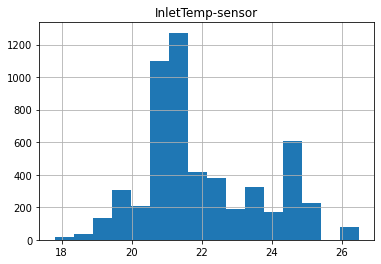

In [9]:
print(f"Skew: {compl_datas['InletTemp-sensor'].skew()}")
print(f"Kurtosis: {compl_datas['InletTemp-sensor'].kurtosis()}")

compl_datas.hist("InletTemp-sensor", bins= 16)

Skew: 0    0.770735
dtype: float64
Kurtosis: 0    5.086615
dtype: float64


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

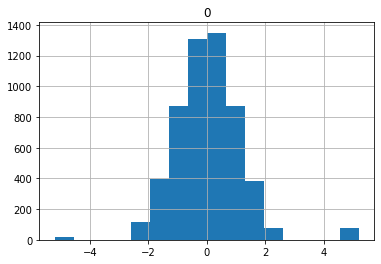

In [10]:
from sklearn.preprocessing import QuantileTransformer

inlet_reshaped = compl_datas["InletTemp-sensor"].to_numpy().reshape(-1, 1)

qt = QuantileTransformer(output_distribution= "normal").fit(inlet_reshaped)
inlet_qt = pd.DataFrame(qt.transform(inlet_reshaped))

print(f"Skew: {inlet_qt.skew()}")
print(f"Kurtosis: {inlet_qt.kurtosis()}")

inlet_qt.hist(bins= 16)

Skew: 1.2674258282595998
Kurtosis: 0.2183195744833788


array([[<AxesSubplot:title={'center':'SetTemp-sensor'}>]], dtype=object)

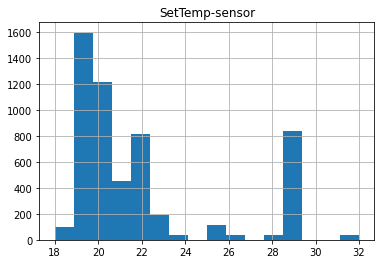

In [11]:
print(f"Skew: {compl_datas['SetTemp-sensor'].skew()}")
print(f"Kurtosis: {compl_datas['SetTemp-sensor'].kurtosis()}")


compl_datas.hist("SetTemp-sensor", bins= 16)

Skew: 0    0.075357
dtype: float64
Kurtosis: 0   -1.320269
dtype: float64


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

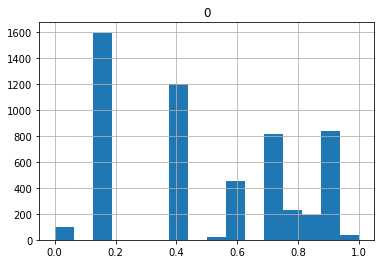

In [12]:
set_reshaped = compl_datas["SetTemp-sensor"].to_numpy().reshape(-1, 1)

qt = QuantileTransformer(output_distribution= "uniform").fit(set_reshaped)
set_qt = pd.DataFrame(qt.transform(set_reshaped))

print(f"Skew: {set_qt.skew()}")
print(f"Kurtosis: {set_qt.kurtosis()}")

set_qt.hist(bins= 16)

In [13]:
for col in compl_datas.columns:
    nb_null = compl_datas[col].isnull().sum()
    if nb_null > 0:
        print(f"{col} -- {nb_null}")

<AxesSubplot:>

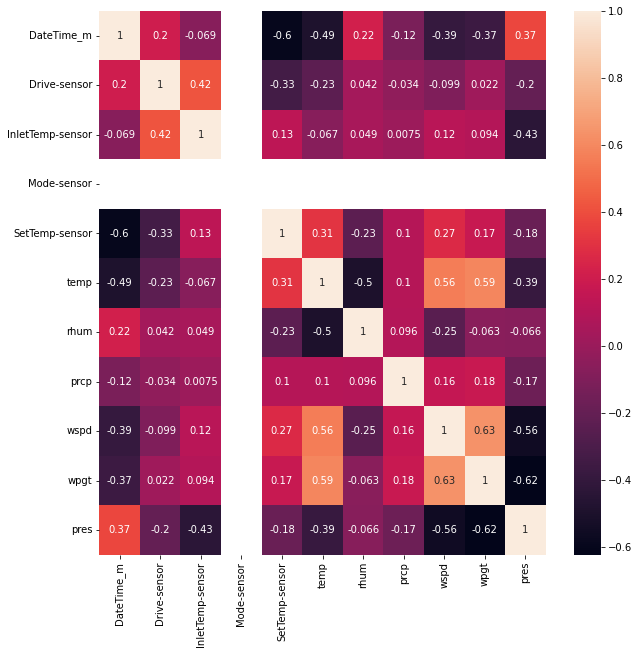

In [14]:
import seaborn as sns

fig = plt.figure(figsize=(10, 10))
sns.heatmap(compl_datas.corr(), annot= True)

In [15]:
from sklearn.model_selection import train_test_split

X_cols = [x for x in compl_datas.columns if x not in ["SetTemp-sensor", "DateTime_m"]]
y_col = "SetTemp-sensor"

X_train, X_test, y_train, y_test = train_test_split(compl_datas[X_cols], compl_datas[y_col], 
    train_size= 0.7, random_state= 42)


In [16]:
from sklearn.compose import TransformedTargetRegressor

In [17]:
from sklearn.preprocessing import StandardScaler

tmp_cols = [x for x in X_train.columns if x not in ["DateTime_m", "Drive-sensor", "Mode-sensor"]]

ssc = StandardScaler()
ssc.fit(X_train[tmp_cols])

X_tr_ssc_nodate = pd.DataFrame(ssc.transform(X_train[tmp_cols]), columns= tmp_cols, index= X_train.index)
X_tr_ssc = pd.concat([X_tr_ssc_nodate, X_train[["Drive-sensor", "Mode-sensor"]]], axis= 1)

X_te_ssc_nodate = pd.DataFrame(ssc.transform(X_test[tmp_cols]), columns= tmp_cols, index= X_test.index)
X_te_ssc = pd.concat([X_te_ssc_nodate, X_test[["Drive-sensor", "Mode-sensor"]]], axis= 1)

In [28]:
import joblib

joblib.dump(ssc, "settemp_ssc.sav")

['settemp_ssc.sav']

In [18]:
# print(X_tr_ssc.columns)
# print(X_te_ssc.columns)
# # X_te_ssc

In [19]:
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score

# lr = TransformedTargetRegressor(LinearRegression(), transformer= QuantileTransformer(output_distribution= "uniform"))
# lr.fit(X_train, y_train)

# y_pred_lr = lr.predict(X_test)

# r2_score(y_test, np.round(y_pred_lr))


In [20]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV



In [21]:
# grid_params = {"regressor": [KernelRidge()], "regressor__alpha": np.logspace(-2, 2, 5), "regressor__kernel": ["linear", "poly", "rbf", 
#         "sigmoid"], "regressor__gamma": np.logspace(-2, 1, 4)}

# gcv = GridSearchCV(TransformedTargetRegressor(transformer=QuantileTransformer(output_distribution="uniform")), grid_params, cv= 5,
#     scoring="r2", n_jobs=-1, verbose=3)

# gcv.fit(X_tr_ssc, y_train)

# print(f"Meilleurs hyperparamètres:")
# print(gcv.best_params_)

# print(f"Meilleur score:")
# print(gcv.best_score_)

* KernelRidge:
  
alpha = 0.01

gamma = 10.0

kernel = "rbf"

In [22]:
from xgboost import XGBRegressor, XGBRFRegressor


In [23]:
# grid_params = {"regressor": [XGBRegressor()], "regressor__reg_lambda": np.logspace(-3, 1, 3), 
#         "regressor__reg_alpha": np.logspace(-2, 2, 3), "regressor__colsample_bytree": [0.6],
#         "regressor__gamma": np.logspace(-2, 1, 3), "regressor__min_child_weight": [1, 3, 5], 
#         "regressor__max_depth": np.logspace(1, 3, 3, base=2, dtype="int"),
#         "regressor__n_estimators": np.logspace(1, 3, 8, dtype="int"), "regressor__subsample": [0.9], 
#         "regressor__objective": ["reg:squarederror"], "regressor__seed": [42]}

# gcv = GridSearchCV(TransformedTargetRegressor(transformer=QuantileTransformer(output_distribution="uniform")), grid_params, cv=5, 
#     scoring="r2", n_jobs=-1, verbose=3)
# gcv.fit(X_tr_ssc, y_train)

# print(f"Meilleurs hyperparamètres:")
# print(gcv.best_params_)

# print(f"Meilleur score:")
# print(gcv.best_score_)

* XGBRegressor

colsample_bytree = 0.6

gamma = 0.01

max_depth = 8

min_child_weight = 1

n_estimators = 1000

objective = reg:squarederror 

reg_alpha = 0.01

reg_lambda = 0.1

seed = 42

subsample = 0.9

In [24]:
grid_params = {"regressor": [XGBRFRegressor()], "regressor__n_estimators": np.logspace(1, 3, 8, dtype="int"), 
        "regressor__max_depth": np.logspace(1, 3, 3, base=2, dtype="int"), 
        "regressor__subsample": [0.9], "regressor__colsample_bynode": [0.2], "regressor__seed": [42],
        "regressor__min_child_weight": [1, 3, 5], "regressor__objective": ["reg:squarederror"],
        "regressor__lambda": np.logspace(-3, 1, 3), "regressor__alpha": np.logspace(-2, 2, 3)}

gcv = GridSearchCV(TransformedTargetRegressor(transformer=QuantileTransformer(output_distribution="uniform")), grid_params, cv=5, 
    scoring="r2", n_jobs= 1, verbose= 3)
gcv.fit(X_tr_ssc, y_train)

print(f"Meilleurs hyperparamètres:")
print(gcv.best_params_)
print(f"Meilleur score:")
print(gcv.best_score_)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV 1/5] END regressor=XGBRFRegressor(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bytree=None, enable_categorical=False, gamma=None,
               gpu_id=None, importance_type=None, interaction_constraints=None,
               max_delta_step=None, max_depth=None, min_child_weight=None,
               missing=nan, monotone_constraints=None, n_estimators=100,
               n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=None,
               reg_alpha=None, scale_pos_weight=None, tree_method=None,
               validate_parameters=None, verbosity=None), regressor__alpha=0.01, regressor__colsample_bynode=0.2, regressor__lambda=0.001, regressor__max_depth=2, regressor__min_child_weight=1, regressor__n_estimators=10, regressor__objective=reg:squarederror, regressor__seed=42, regressor__subsample=0.9;, score=-0.104 total time=   

* XGBRFRegressor

colsample_bynode = 0.2

max_depth = 8

min_child_weight = 5

n_estimators = 268

objective = reg:squarederror

reg_alpha = 0.01

reg_lambda = 0.001

seed = 42

subsample': 0.9

In [25]:
from sklearn.svm import SVR

grid_params = {"regressor": [SVR()], "regressor__kernel": ["linear", "poly", "rbf", "sigmoid"], "regressor__verbose": [True],
        "regressor__C": np.logspace(-2, 3, 6), "regressor__epsilon": np.logspace(-3, 0, 6)}

gcv = GridSearchCV(TransformedTargetRegressor(transformer=QuantileTransformer(output_distribution="normal")), grid_params, cv=5, 
    scoring="r2", n_jobs=-1, verbose=3)
gcv.fit(X_tr_ssc, y_train)

print(f"Meilleurs hyperparamètres:")
print(gcv.best_params_)
print(f"Meilleur score:")
print(gcv.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [ ]:
from datetime import datetime, timedelta

datetime_m = datetime.timestamp(datetime.now())

# print(datetime_m)
# print(X_test.iloc[0, 0])

results_list = []
for i in np.arange(16, 32.1, 0.5):
    drive = 1.0
    inlet = i
    mode = 2.0

    m_datas = Hourly(Paris, datetime.now() - timedelta(hours= 1), datetime.now())
    m_datas = m_datas.fetch()
    m_datas = m_datas.reset_index(drop= True)


    temp = m_datas.loc[0, "temp"]
    rhum = m_datas.loc[0, "rhum"]
    prcp = m_datas.loc[0, "prcp"]
    wspd = m_datas.loc[0, "wspd"]
    wpgt = m_datas.loc[0, "wpgt"]
    pres = m_datas.loc[0, "pres"]

    df_test = pd.DataFrame([[inlet, temp, rhum, prcp, wspd, wpgt, pres, drive, mode]], 
        columns= X_tr_ssc.columns)
    # print(df_test)

    df_tmp = pd.DataFrame(ssc.transform(df_test[tmp_cols]), columns= tmp_cols)
    df_test = pd.concat([df_tmp, df_test[["Drive-sensor", "Mode-sensor"]]], axis= 1)


    # print(f"df_test {i}: {krr.predict(df_test)}")
    results_list.append(krr.predict(df_test))


# print(X_te_ssc[:1])
# print(f"X_test: {krr.predict(X_te_ssc[:1])}")


In [ ]:
fig = plt.figure(figsize=(10, 10))

plt.plot([x for x in np.arange(16, 32.1, 0.5)], results_list)